cpu


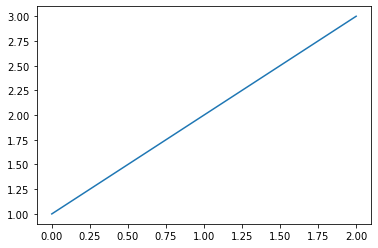

In [1]:
from matplotlib import pyplot as plt
plt.plot([1,2,3])
import numpy as np
import scipy
import scipy.spatial as spatial
from scipy.optimize import linear_sum_assignment
import copy
from Environment.Builder_Env import Structure_Builder
from RL.sac import sac_agent
import matplotlib
import torch
from Environment.data_visualization import plot_graph, show_reset, show_done, show_step
from Environment.episode_memory import Episode_Memory
matplotlib.rcParams['image.cmap'] = 'gray'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

In [41]:
import importlib
import Builder_Env
importlib.reload(Builder_Env)
from Builder_Env import Structure_Builder

In [3]:
folder = 'building_4'

In [4]:
def circle(x, y, r, p = 100):
    x_, y_ = [], []
    for i in range(p):
        x_.append(x+r*np.cos(2*i*np.pi/p))
        y_.append(y+r*np.sin(2*i*np.pi/p))
    return x_, y_

def assignment(start, goal):
    cost_matrix = spatial.distance.cdist(np.array(start)[:,:2], np.array(goal)[:,:2])
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    cost = cost_matrix[row_ind, col_ind]
    total_cost = np.sum(cost)
    return np.array(start)[row_ind,:], np.array(goal)[col_ind,:], cost, total_cost

def RL_operation(env, agent, final_destination_absolute_nm, atom_nm, len_nm, i_episode):
    offset_nm = atom_nm +np.array([0,-0.5*len_nm])
    done = False
    state, info = env.reset(final_destination_absolute_nm, offset_nm, len_nm)
    show_reset(env.img_info['img_forward'], env.img_info['offset_nm'], env.img_info['len_nm'], 
               env.atom_start_absolute_nm, env.destination_absolute_nm, np.array([0,0]), np.array([0,0]))

    episode_memory.update_memory_reset(env.img_info, i_episode, info)
    for step in range(max_steps):
        print('step:', step)
        action = agent.select_action(state)
        atom_absolute_nm = env.atom_absolute_nm
        next_state, reward, done, info = env.step(action)
        print(reward)
        mask = float(not done)
        episode_memory.update_memory_step(state, action, next_state, reward, done, info)
        state=next_state
        show_step(env.img_info['img_forward'], env.img_info['offset_nm'], env.img_info['len_nm'], 
                  info['start_nm']+atom_absolute_nm, info['end_nm']+atom_absolute_nm,env.atom_absolute_nm, 
                  env.atom_start_absolute_nm, env.destination_absolute_nm, np.array([0,0]), np.array([0,0]), 
                  action[4]*env.max_mvolt, action[5]*env.max_pcurrent_to_mvolt_ratio*action[4]*env.max_mvolt)
        if done:
            episode_memory.update_memory_done(env.img_info, env.atom_absolute_nm, np.array([0,0]))
            episode_memory.save_memory(folder)
            show_done(env.img_info['img_forward'], env.img_info['offset_nm'], 
                      env.img_info['len_nm'], env.atom_absolute_nm, env.atom_start_absolute_nm, 
                      env.destination_absolute_nm, np.array([0,0]), np.array([0,0]), reward, np.array([0,0]))
            break
    return env.atom_absolute_nm, env.dist_destination

def check_line_of_sight(current, goal, index, acceptable_d):
    
    def get_line(s,g):
        a = (g[1] - s[1])/(g[0] - s[0])
        b = -1
        c = s[1]-s[0]*(g[1] - s[1])/(g[0] - s[0])
        return a, b, c
    
    def distance(point,a,b,c):
        point = point.reshape((-1,2))
        d = np.abs(a*point[:,0]+b*point[:,1]+c)/np.sqrt(a**2+b**2)
        return d
    
    a,b,c = get_line(current[index,:], goal[index,:])
    d = distance(current, a,b,c)
    print(d)
    points_on_the_way = (d<acceptable_d)
    points_on_the_way *= ((current[:,0] - min(current[index,0],goal[index,0]) + acceptable_d)*(current[:,0] - max(current[index,0],goal[index,0]) -acceptable_d)<0)*((current[:,1] - min(current[index,1],goal[index,1]) + acceptable_d)*(current[:,1] - max(current[index,0],goal[index,1]) -acceptable_d)<0)
    points_on_the_way[index] = False
    
    return points_on_the_way

In [7]:
batch_size= 64
LEARNING_RATE = 0.0003
agent = sac_agent(num_inputs = 4, num_actions = 6, action_space = None, device=device, hidden_size=256, lr=LEARNING_RATE,
                 gamma=0.9, tau=0.005, alpha=1)
agent.critic.load_state_dict(torch.load('training_4/reward_2_critic_2240.pth'))
agent.policy.load_state_dict(torch.load('training_4/reward_2_policy_2240.pth'))
agent.alpha = torch.load('training_4/reward_2_alpha_2240.pth')
episode_memory = Episode_Memory()


In [45]:
step_nm = 0.4
max_mvolt = 15 #min_mvolt = 0.5*max_mvolt
max_pcurrent_to_mvolt_ratio = 6E3 # min = 0.5*max
goal_nm  = 1.5
current_jump  = 4
large_len_nm = 9.033

large_offset_nm = np.array([8.457,317.641])
pixel = 128
manip_limit_nm = np.zeros(4) #[left, right, up, down]
scan_mV = 1000
max_len = 5
env = Structure_Builder(step_nm, max_mvolt, max_pcurrent_to_mvolt_ratio, goal_nm, 
                 current_jump, large_len_nm, large_offset_nm, manip_limit_nm, pixel, 
                 scan_mV, max_len)

succeed to connect


The scan will take 17.7 seconds
[ 11.404 317.596]
[18.06696 18.06696]
[  8 322] 24.73684334632692


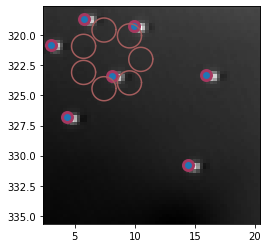

In [27]:
### Set design offset values

scan_mV= 10
design_nm = np.array(circle(0,0,2.5,p=7)).T
all_atom_absolute_nm, img_forward, img_backward, offset_nm, len_nm = env.scan_all_atoms(large_offset_nm, large_len_nm)    
fig, ax = plt.subplots()
extent = (offset_nm[0]-0.5*len_nm[0], offset_nm[0]+0.5*len_nm[0], offset_nm[1]+len_nm[0], offset_nm[1])
ax.imshow(img_forward, extent = extent)
ax.scatter(all_atom_absolute_nm[:,0],all_atom_absolute_nm[:,1],edgecolor='#A53860', linewidth=3, s=100)

assert all_atom_absolute_nm.shape == design_nm.shape
c_min = np.inf
xy_min = np.array([None, None])
for x in range(int(np.min(all_atom_absolute_nm[:,0])),int(np.max(all_atom_absolute_nm[:,0]))):
    for y in range(int(np.min(all_atom_absolute_nm[:,1])),int(np.max(all_atom_absolute_nm[:,1]))):
        s, d,_, c = assignment(all_atom_absolute_nm, design_nm + np.array([x,y]))
        if c < c_min:
            c_min = c
            xy_min = np.array([x,y])
            start_ordered, design_ordered = s, d
print(xy_min, c_min)
r = 1
for g in design_ordered:
    x, y = circle(g[0], g[1], r)
    ax.plot(x,y, color='#A45D5D')
    
np.save(folder+'/design.npy', design_ordered)

In [43]:
acceptable_d = 1.5
precision = 0.2

def reset_large_scan_frame():
    fig, ax = plt.subplots()
    all_atom_absolute_nm, img_forward, img_backward, offset_nm, len_nm = env.scan_all_atoms(large_offset_nm, large_len_nm)    
    img_info = {'img_forward':img_forward,'img_backward':img_backward, 'offset_nm':offset_nm, 'len_nm':len_nm, 
                'all_atom_absolute_nm':all_atom_absolute_nm, 'all_atom_absolute_nm_f':env.all_atom_absolute_nm_f,
                'all_atom_absolute_nm_b':env.all_atom_absolute_nm_b}
    start, design, cost, total_cost = assignment(all_atom_absolute_nm, design_ordered)
    print('total movement:',total_cost)
    extent = (offset_nm[0]-0.5*len_nm[0], offset_nm[0]+0.5*len_nm[0], offset_nm[1]+len_nm[0], offset_nm[1])
    ax.imshow(img_forward, extent = extent)
    print(cost)
    if np.max(cost)>precision:
        building_done = False
    else:
        building_done = True
        return building_done, None, None, img_info
    if not building_done:
        num_atoms_on_the_way = []
        for i in range(start.shape[0]):
            num_atoms_on_the_way.append(np.sum(check_line_of_sight(start, design, i, acceptable_d)))
        arg = np.argsort(num_atoms_on_the_way)  
        num_atoms_on_the_way = np.array(num_atoms_on_the_way)[arg]
        start = start[arg,:]
        design = design[arg,:]
        for g in design:
            x, y = circle(g[0], g[1], r)
            ax.plot(x,y, color='#A45D5D')
        for g in start:
            x, y = circle(g[0], g[1], r)
            ax.plot(x,y, color='#4A403A')
        for i in range(start.shape[0]):
            if (np.linalg.norm(design[i,:] - start[i,:])> precision) and num_atoms_on_the_way[i]==0:
                break
        for j in range(start.shape[0]):
            plt.arrow(start[j,0],start[j,1], (design-start)[j,0], (design-start)[j,1], width=0.1,length_includes_head=True, color='#FFC069')
            fs = 14
            if j==i:
                fs = 20
            plt.annotate(j, (start[j,0], start[j,1]), fontsize=fs)
        
        return building_done, design[i,:], start[i,:], img_info
 

The scan will take 38.7 seconds
[  8.457 317.641]
[8.94314 8.94314]
total movement: 1.9607634369450528
[0.07343751 0.62984133 0.1403289  0.09483586 0.11615809 0.63020058
 0.27596117]
[0.         1.60907303 1.12840825 3.86566981 0.20447529 1.84573998
 3.45424682]
[1.50098337 0.         3.76139508 0.20271149 4.84482719 3.66442144
 2.16461709]
[2.18531046 3.27159177 0.         2.07512223 1.66899588 1.14774112
 0.06260915]
[1.24417252 0.24362939 3.50708069 0.         4.61699069 3.46049638
 1.97387518]
[3.53108031 4.93428731 1.2627562  4.44832221 0.         1.00946576
 2.41148694]
[0.84213508 0.89159076 2.41440523 2.6419517  1.99299057 0.
 1.7329237 ]
[3.00896754 3.80544271 0.98371493 2.12004609 0.92122933 0.79540454
 0.        ]
destination: [  9.5587245  320.04542129] start: [  9.23328169 319.50617453]
The scan will take 38.7 seconds
forward: [  9.2902505 319.4750171] backward: [  9.13713618 319.47581164]


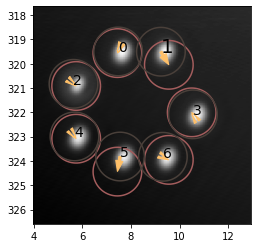

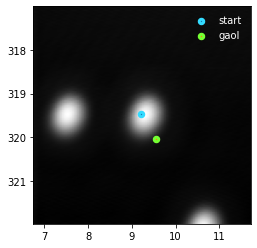

step: 0
-0.05430306196212769 -0.22077016830444338 1.1205661296844482 1.450760006904602 5.718827247619629 26141.257584328057
63 58 93 101
The scan will take 38.7 seconds
forward: [  9.90418935 320.04890578] backward: [  9.75230224 320.04645285]
atom moves by: 0.8397391762255355
None


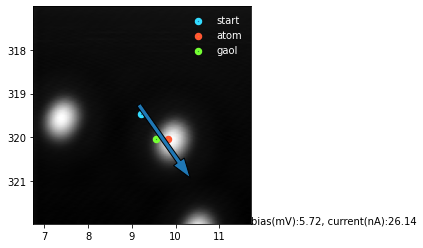

step: 1
0.39414868354797367 -0.1584420680999756 0.3382915109395981 1.2052340805530548 7.908776700496674 26434.066728714748
90 74 88 109
The scan will take 38.7 seconds
forward: [  9.68679156 320.4240969 ] backward: [  9.53238222 320.41860735]
atom moves by: 1.0254413385882328
None


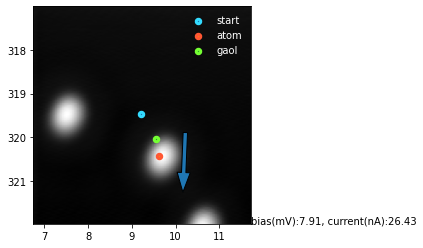

step: 2
0.3505389213562012 -0.053467708826065066 0.4011834114789963 0.3977288603782654 9.820487201213837 44758.18164285837
83 87 84 98
The scan will take 38.7 seconds
forward: [  9.32190346 320.71843165] backward: [  9.16733968 320.71625857]
atom moves by: 1.2423157870734134
None


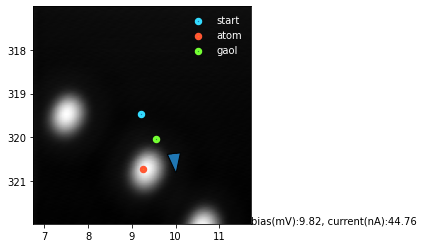

step: 3
-0.19880853891372682 0.01199343055486679 0.7336315959692001 0.2525632157921791 7.4732208251953125 41566.852726664365
60 96 84 102
The scan will take 38.7 seconds
forward: [  9.48485111 320.00856525] backward: [  9.33067395 320.00607146]
atom moves by: 0.5662019931491081
None


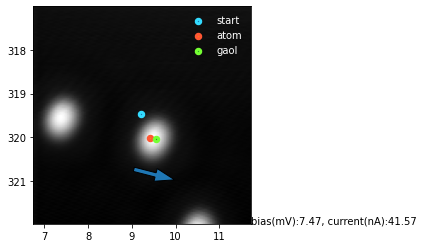

step: 4
0.1815088987350464 -0.029174983501434326 0.6962859034538269 1.13901686668396 6.9504766166210175 21945.36452512093
74 77 87 107
The scan will take 38.7 seconds
forward: [  9.79507586 320.29680277] backward: [  9.64126235 320.29488881]
None


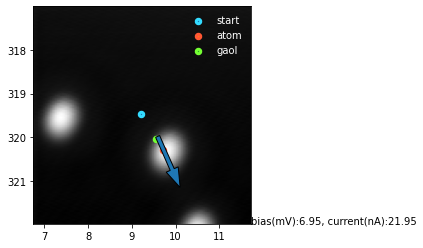

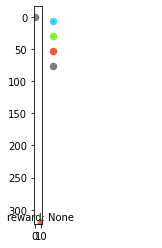

The scan will take 38.7 seconds
[  8.457 317.641]
[8.94314 8.94314]
total movement: 2.074653684300375
[0.1338841  0.29865056 0.2693407  0.16092449 0.231791   0.5746346
 0.40542823]
[0.         0.22354934 1.70205582 1.86404103 3.80979653 4.20955463
 3.84070869]
[1.58816548 0.         3.85462819 0.45158733 5.02082868 3.90854718
 2.448566  ]
[1.60975015 1.23672129 0.         0.46329995 2.13401051 2.65301917
 2.3871976 ]
[4.02457068 1.69997817 4.54178245 0.         3.10104411 1.136057
 0.20514967]
[3.78641368 3.50624452 2.1185539  1.84255715 0.         0.44502015
 0.11497966]
[0.22277128 2.57267889 1.70031525 3.11056845 1.81789687 0.
 1.75373415]
[3.88802101 3.62047604 2.21245606 1.96189244 0.09622241 0.33871564
 0.        ]
destination: [  9.5587245  320.04542129] start: [  9.72388952 320.29424388]
The scan will take 38.7 seconds
forward: [  9.78114677 320.27380614] backward: [  9.62830875 320.27112651]


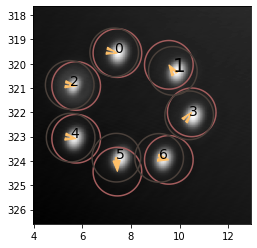

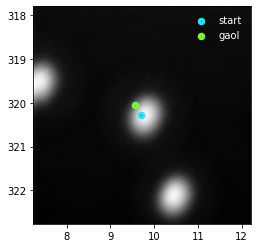

step: 0
0.23916797637939455 0.36401891708374023 0.2379414215683937 0.296053871512413 7.6054564118385315 43712.67942950581
70 73 70 71
None


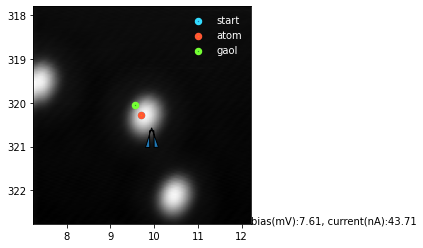

step: 1
0.0848548173904419 0.35187635421752933 0.27647922188043594 0.19588156789541245 5.297988653182983 23449.786392170325
66 73 71 69
None


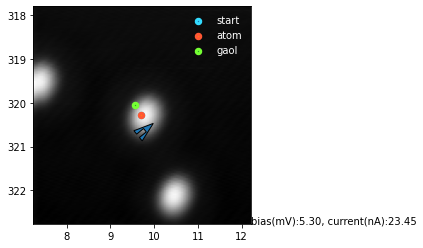

step: 2
-0.006111479923129082 0.3561877489089966 0.15202180668711662 0.2710050791501999 7.845567762851715 35661.904190105
64 73 68 71
The scan will take 38.7 seconds
forward: [  9.43828766 319.81865165] backward: [  9.28493332 319.81485513]
atom moves by: 0.5704417037516805
None


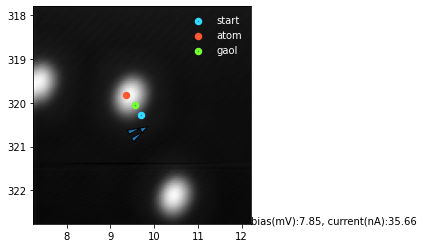

step: 3
0.0006133253686130048 0.17775309085845947 0.7617618441581726 0.8493205904960632 8.044102191925049 43563.68827121628
55 57 75 74
The scan will take 38.7 seconds
forward: [  9.56091447 319.72766935] backward: [  9.40525839 319.7238487 ]
atom moves by: 0.5899269010884878
None


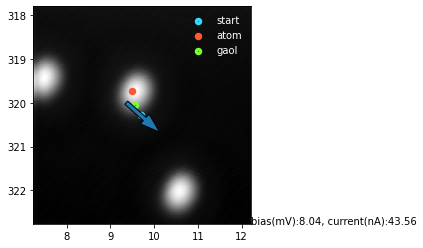

step: 4
-0.03595277667045593 0.28950750827789307 0.7192925065755844 0.7646423578262329 9.151861667633057 40204.480755784854
57 57 77 69
The scan will take 38.7 seconds
forward: [  9.65032442 319.45269522] backward: [  9.49934705 319.45116951]
None


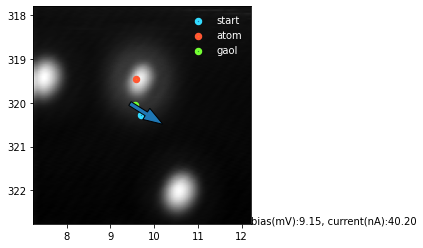

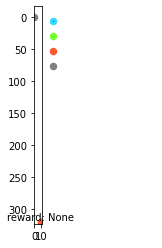

The scan will take 38.7 seconds
[  8.457 317.641]
[8.94314 8.94314]
total movement: 2.2320973174049694
[0.15242479 0.60213027 0.22834554 0.00847121 0.19975735 0.69230803
 0.34866013]
[0.         2.14729748 2.0173738  2.65488525 2.30018015 0.56565006
 1.16945028]
[2.17486637 0.         3.91858942 1.07151516 3.73120617 1.7998367
 0.04591984]
[2.24547907 3.75578178 0.         2.5747206  1.50633376 0.76804534
 0.4618862 ]
[1.3053183  0.54388638 3.5698287  0.         4.64727137 3.46076558
 1.96044607]
[3.49389115 5.24818716 1.22031801 4.49907987 0.         1.05259612
 2.47736038]
[0.52709054 1.64256741 2.21830234 2.8014597  1.95491262 0.
 1.7491582 ]
[2.56046099 3.7552106  0.41955645 2.14249329 1.34873635 0.97716884
 0.        ]
destination: [  9.5587245  320.04542129] start: [  9.59797528 319.44457169]
The scan will take 38.7 seconds
forward: [  9.65828662 319.43853215] backward: [  9.50524886 319.4336408 ]


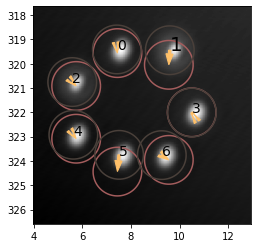

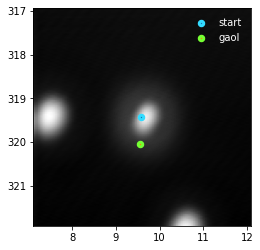

step: 0
0.29529237747192383 -0.2114654779434204 0.4848267138004303 1.439863532781601 5.503995269536972 29322.627889808875
72 59 76 101
The scan will take 38.7 seconds
forward: [  9.5425196  320.91857747] backward: [  9.38084491 320.93813013]
atom moves by: 1.4970912784466435
None


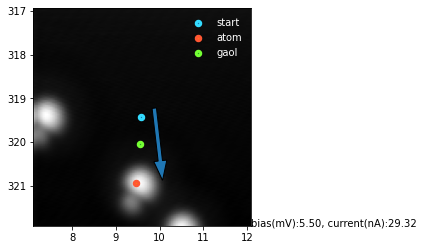

step: 1
-0.1712495803833008 0.3625706434249878 0.7288353592157364 0.23450589179992676 7.003835141658783 39323.410943215116
56 112 80 109
The scan will take 38.7 seconds
forward: [  9.76475084 320.12672818] backward: [  9.60690302 320.12510474]
atom moves by: 0.6976343772421726
None


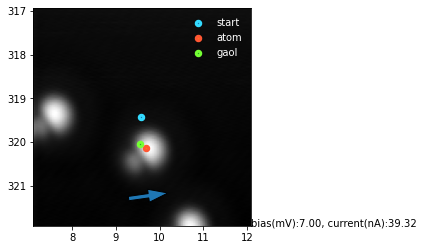

step: 2
0.0677992820739746 0.015418943762779237 0.271586649119854 1.1216709315776825 8.668066263198853 36743.284679414784
68 82 74 111
The scan will take 38.7 seconds
forward: [  9.64380981 321.26536903] backward: [  9.48309653 321.25965559]
atom moves by: 1.826517658931445
None


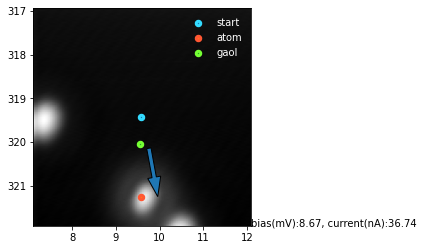

step: 3
-0.25950930118560794 0.32784409523010255 0.04664832539856434 -0.16220969706773758 10.413282215595245 48723.77997067798
57 120 65 107
The scan will take 38.7 seconds
forward: [  9.63405702 321.13413119] backward: [  9.47888734 321.13306508]
atom moves by: 1.6977001249141948
None


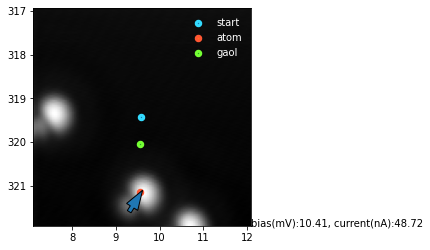

step: 4
-0.009697293490171434 0.24017319679260254 0.2816050797700882 0.23455531150102615 14.498083591461182 85890.4394592048
63 114 71 114
The scan will take 38.7 seconds
forward: [  9.75182432 321.02944914] backward: [  9.59876124 321.03253018]
None


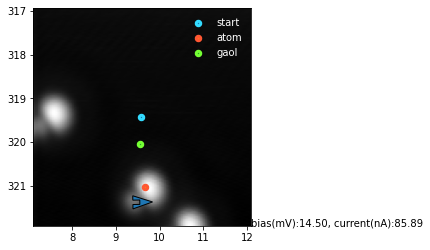

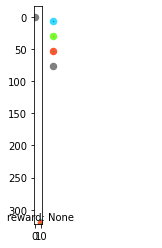

The scan will take 38.7 seconds
[  8.457 317.641]
[8.94314 8.94314]
total movement: 3.04231549044525
[0.26738829 0.21537311 1.00515608 0.1527468  0.26065867 0.80560041
 0.33539213]
[0.         1.2301629  2.63210404 3.83861237 0.31010908 1.7487082
 3.3786872 ]
[2.39605879 0.         3.09859873 3.3506265  1.1237854  0.09205074
 1.32834924]
[1.91113946 3.9930178  0.         0.83578817 4.11218431 2.34009126
 0.59013852]
[3.90281204 3.86763407 1.25621829 0.         2.10004914 0.32656772
 0.70617722]
[1.76155702e+00 1.50179891e-01 3.91040901e+00 4.86468183e+00
 1.12317130e-15 1.89244227e+00 3.65558163e+00]
[1.11304596 2.64657351 1.36733204 2.49162057 2.02742311 0.
 1.71437599]
[0.46277798 1.91112372 1.5030205  1.91593859 2.7976661  1.54375752
 0.        ]
destination: [  7.44369767 319.56268022] start: [  7.5464574  319.31582614]
The scan will take 38.7 seconds
forward: [  7.6609411  319.30825614] backward: [  7.51260619 319.30059914]


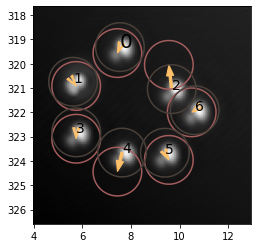

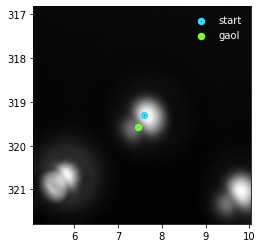

step: 0
0.22885696887969972 0.19319928884506227 0.18953613191843033 1.087484210729599 7.046691924333572 41274.63931402257
71 69 70 92
The scan will take 38.7 seconds
forward: [  7.27840599 319.33273096] backward: [  7.01265101 319.29712156]
atom moves by: 0.4413700227373123
None


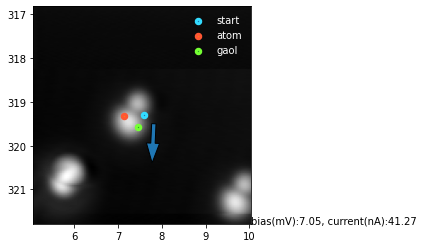

step: 1
-0.20267770290374756 0.2621947288513184 0.74786277115345 1.0114983916282654 5.907084345817566 21875.461807311895
49 71 73 90
The scan will take 21.0 seconds
forward: [  7.53390297 319.40288837] backward: [  7.39459901 319.40347444]
atom moves by: 0.15736615043892715
None


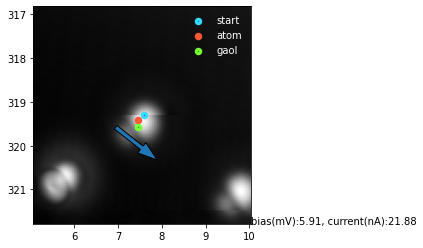

step: 2
0.11434928178787232 0.2987562656402588 0.31936436891555786 0.8503760397434235 6.188517361879349 30598.774223522545
65 74 71 89
None


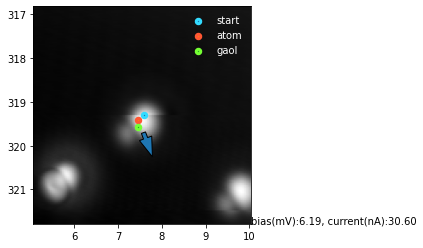

step: 3
0.1415761113166809 0.24990296363830566 0.28735750168561935 0.8662326335906982 5.568360686302185 18629.816892960134
66 73 70 89
The scan will take 21.0 seconds
forward: [  7.48015528 319.34069713] backward: [  7.18640571 319.34350958]
atom moves by: 0.25627765138241065
None


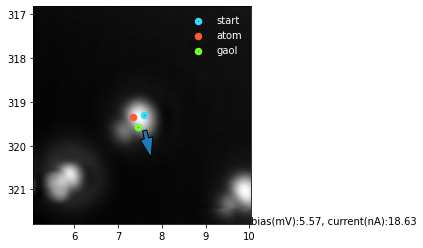

step: 4
0.07051594853401184 0.2626130819320679 0.5561010539531708 1.0403067469596863 7.747333645820618 28849.943583662993
61 72 73 92
The scan will take 41.9 seconds
forward: [  7.54822891 319.40117224] backward: [  7.40417101 319.4017432 ]
None


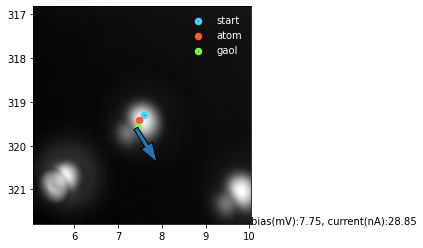

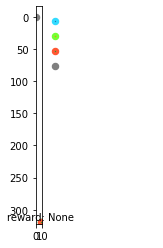

The scan will take 41.9 seconds
[  8.457 317.641]
[8.94314 8.94314]
total movement: 3.036953963486207
[0.16740564 0.24546691 0.97515633 0.17289577 0.28488742 0.83933752
 0.35180437]
[0.         1.79809958 2.23980687 3.16585207 1.71096415 0.16290313
 1.91440251]
[2.13499139 0.         3.63852042 4.1840067  0.67663402 0.77064652
 2.39315903]
[2.00153365 3.95322179 0.         0.79923248 4.14855949 2.40364812
 0.67243584]
[3.95152662 4.07922061 1.27327104 0.         2.37291757 0.54500355
 0.5756745 ]
[1.4477832  0.24804462 3.80597053 4.79715024 0.         1.93263659
 3.68171431]
[1.23418544 2.64902696 1.34891517 2.47095766 2.02660252 0.
 1.70274536]
[0.15773678 2.01714918 1.44799514 1.88798232 2.86931604 1.55737529
 0.        ]
destination: [  5.74757783 320.91529065] start: [  5.65720188 320.68706666]
The scan will take 41.9 seconds
forward: [  5.76182322 320.72486506] backward: [  5.61222054 320.7253146 ]


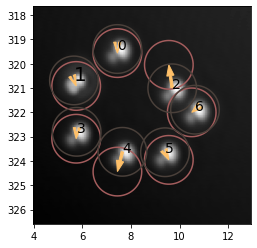

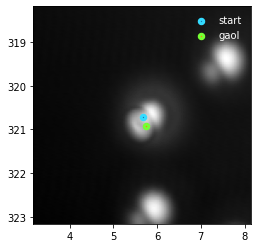

step: 0
0.2485372304916382 0.2015464544296265 0.4258240610361099 0.7806412875652313 5.7625991106033325 17937.12263781103
72 71 76 86
The scan will take 41.9 seconds
forward: [  5.75797843 320.68718801] backward: [  5.6140954  320.68426896]
atom moves by: 0.039373663382143584
None


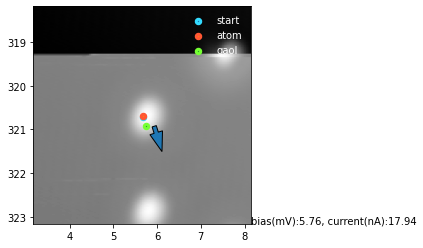

step: 1
0.0509405255317688 0.017418257892131805 0.6039330661296844 0.8662186861038208 9.226190149784088 29314.731195160453
66 65 81 87
The scan will take 41.9 seconds
forward: [  5.90033042 320.72751581] backward: [  5.75552846 320.72631674]
atom moves by: 0.1409193955960266
None


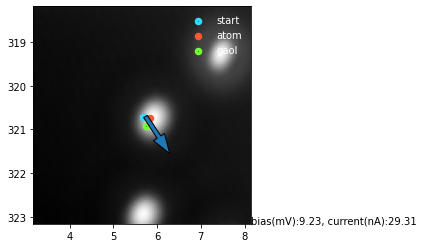

step: 2
0.07811339497566223 0.08926128745079041 0.42030447721481323 0.8135527968406677 8.031025528907776 26780.779270191957
71 68 80 86
None


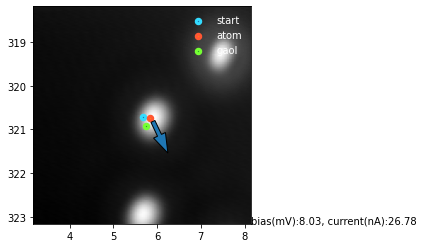

step: 3
0.2646806240081787 0.14405993223190308 0.3179349973797798 0.8765748739242554 9.676845073699951 29769.971172636928
76 69 77 88
The scan will take 41.9 seconds
forward: [  5.61803052 320.60976938] backward: [  5.47312832 320.60608688]
atom moves by: 0.18366500251343792
None


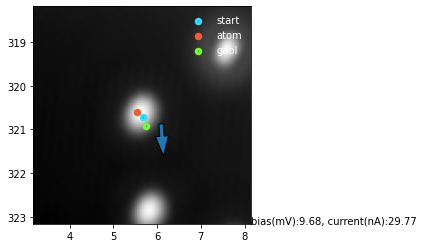

step: 4
-0.1381741166114807 0.16548161506652834 0.723434329032898 0.9111416637897491 5.972668826580048 23820.668853556555
58 67 80 86
The scan will take 41.9 seconds
forward: [  5.76337292 320.66827131] backward: [  5.61980543 320.66757331]
None


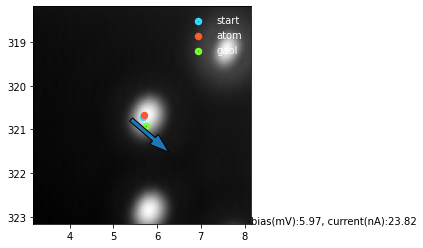

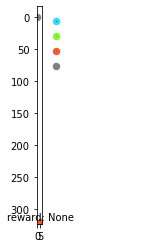

In [48]:
max_steps = 5
for i in range(35,40):
    building_done, d, s, img_info = reset_large_scan_frame()
    if building_done:
        break
    np.save(folder+'/{}_episode_img_info.npy'.format(i),img_info)
    small_len_nm = 5
    print('destination:',d, 'start:',s)
    atom_nm, dist_destination = RL_operation(env, agent, d, s, small_len_nm,i)
    
        

In [32]:
from get_atom_coordinate import blob_detection

In [33]:
blob_detection(img_info['img_forward'])

(array([[19.20106697, 24.23781013],
        [11.31914139,  9.73920727],
        [24.47812843, 20.51727867],
        [29.80204201, 14.78679276],
        [25.11744499,  8.86454678],
        [13.01351738, 21.67724991],
        [18.02427483,  6.0947938 ]]),
 array([2.19874215, 2.24661613, 1.41421354, 2.24661613, 2.41421366,
        2.23606801, 2.19874215]))

In [34]:
blob_detection(img_info['img_backward'])

(array([[10.50926113, 21.49681664],
        [16.60109138, 24.34771919],
        [21.67941093, 20.5453186 ],
        [27.33747482, 14.67805767],
        [ 8.92508888,  9.89049911],
        [22.58078766,  8.64076233],
        [15.56712055,  6.28732491]]),
 array([1.41421354, 2.24661613, 2.23606801, 2.41421366, 2.28229904,
        2.24661613, 2.24661613]))